In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


### Lectures Work

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)


32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi={s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# print(itos)


In [16]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)


In [14]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# training, dev, and test split
# 80%, 10%, 10% 
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])




torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [17]:
C = torch.randn((27,2))
emb = C[X]


In [18]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)


In [19]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2,:]], 1).shape


torch.Size([228146, 6])

In [20]:
torch.cat(torch.unbind(emb, 1), 1).shape


torch.Size([228146, 6])

In [21]:
a = torch.arange(18)


In [22]:
a.shape


torch.Size([18])

In [23]:
a.view(3, 3, 2)


tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [24]:
emb.shape


torch.Size([228146, 3, 2])

In [26]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)


In [27]:
h.shape


torch.Size([228146, 100])

In [28]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)


In [29]:
logits = h @ W2 + b2
logits.shape


torch.Size([228146, 27])

In [30]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)


In [ ]:
loss = -prob[torch.arange(32), X].log().mean()
loss


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [182580]

Make it respectable

In [32]:
Xtr.shape, Ytr.shape


(torch.Size([182580, 3]), torch.Size([182580]))

In [33]:
g =torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [34]:
sum(p.nelement() for p in parameters)


11897

In [35]:

for p in parameters:
    p.requires_grad = True



In [36]:
lre = torch.linspace(-3, 0,1000)
lrs = 10**lre


In [37]:
lri = []
lossi = []
stepi = []


In [38]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    # counts=logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())


    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    # lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    # lri.append(lr)
    lossi.append(loss.log10().item()) 


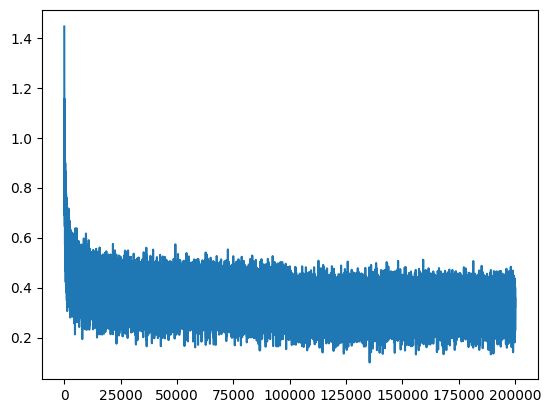

In [39]:
plt.plot(stepi, lossi)


In [40]:
print(loss.item())
# re run again


2.1106529235839844


In [41]:
emb = C[Xdev] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()


2.164260149002075

In [42]:
emb = C[Xtr] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()


2.119372606277466

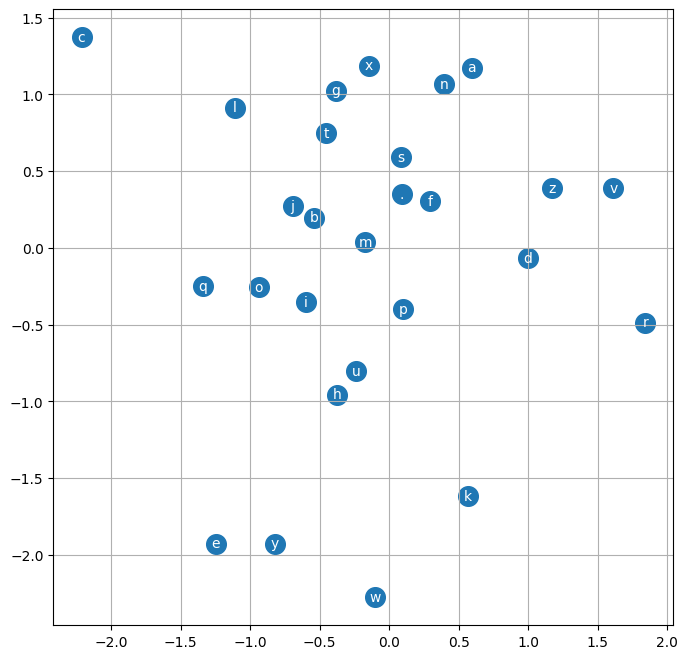

In [13]:
plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s =200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va="center", color="white")
plt.grid("minor")


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


carmah.
amelle.
khyrmyli.
taty.
skansh.
emmahne.
faverynt.
kaeli.
ner.
kia.
chaiir.
kaleigh.
ham.
joce.
quint.
shon.
emira.
bico.
jero.
dearynn.


Exercises

### E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

* no of neurons in the hidden layer

* embedding size

* no of characters

* epochs

* learning rate; change/decay it over the epochs

* batch size

In [14]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
import math


In [ ]:
g =torch.Generator().manual_seed(2147483647)
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [25]:

# training, dev, and test split
# 80%, 10%, 10% 
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])



torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [26]:
def eval_loss(parameters, X, Y, block_size = 3, embedding_size = 10):
    # forward pass
    C, W1, b1, W2, b2 = parameters
    emb = C[X] #(32, 3, 2)
    h = torch.tanh(emb.view(-1, block_size* embedding_size) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    # counts=logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    return loss



In [27]:
# g =torch.Generator().manual_seed(2147483647)
# C = torch.randn((27,10), generator=g)
# W1 = torch.randn((30, 300), generator=g)
# b1 = torch.randn(300,generator=g)
# W2 = torch.randn((300,27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]


Add a smoothing function

In [28]:
def _smmoothing_loss(parameters, lambdas):
    C = parameters[0]
    W1 = parameters[1]
    W2 = parameters[3]
    return lambdas[0]*(C**2).mean() + lambdas[1]*(W1**2).mean() + lambdas[2]*(W2**2).mean()


In [39]:
def train(X, Y, epochs, block_size=3, batch_size=32, embedding_size=10, hidden_neuron=10, parameters=[], lambdas=[0, 0, 0], lr = 0.1):
    if not parameters:
        # Initialize parameters if not provided
        C = torch.randn((27, embedding_size), generator=g)
        W1 = torch.randn((block_size * embedding_size, hidden_neuron), generator=g)
        b1 = torch.randn(hidden_neuron, generator=g)
        W2 = torch.randn((hidden_neuron, 27), generator=g)
        b2 = torch.randn(27, generator=g)
        parameters = [C, W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    sum(p.nelement() for p in parameters)  # (not used, just counts parameters)

    lre = torch.linspace(-3, 0, 1000)
    lrs = 10**lre 

    i = 0  
    batches_per_epoch = X.shape[0]
    for epoch in range(epochs):
        # Sample a minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,))
        i += 1
        # Forward pass: compute loss
        loss = eval_loss(parameters, X[ix], Y[ix], block_size, embedding_size)
        smmoothing_loss = _smmoothing_loss(parameters, lambdas)
        loss += smmoothing_loss

        # Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update parameters
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if epoch % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{epochs:7d} steps: loss = {loss.item():.4f}')
    
    return parameters, loss.item()


In [40]:
parameters, loss = train(Xtr, Ytr, 100_000, block_size=3, embedding_size=50, hidden_neuron=100, batch_size=16384)


      1/ 100000 steps: loss = 19.8007
  10001/ 100000 steps: loss = 2.3119
  20001/ 100000 steps: loss = 2.2044
  30001/ 100000 steps: loss = 2.1627
  40001/ 100000 steps: loss = 2.1721
  50001/ 100000 steps: loss = 2.1371
  60001/ 100000 steps: loss = 2.1039
  70001/ 100000 steps: loss = 2.1277
  80001/ 100000 steps: loss = 2.1130
  90001/ 100000 steps: loss = 2.1180


In [41]:
loss, eval_loss(parameters, Xdev, Ydev, block_size=3, embedding_size=50)


(2.080284357070923, tensor(2.1747, grad_fn=<NllLossBackward0>))

After tuning the parameters by adding smoothing of the training to get the loss of 2.08 in the validation set